In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import ast

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.stats as st
from scipy.stats import uniform, randint
from sklearn.metrics import recall_score, make_scorer, f1_score
from sklearn.decomposition import PCA


In [50]:
all_my_features=pd.read_csv('data/all_my_features.csv')

In [51]:
all_my_features=all_my_features[all_my_features['gameweek']>4]

In [52]:
label_encoder = LabelEncoder()
all_my_features['label'] = label_encoder.fit_transform(all_my_features['result'])

Separating training and testing datasets

In [53]:
train=all_my_features[~all_my_features['competition'].str.contains('English')]

In [54]:
test=all_my_features[all_my_features['competition'].str.contains('English')]

In [55]:
X_train=train.drop(columns=['gameweek', 'dateutc', 'competition', 'result', 'label'])
y_train=train['label']

### Scaling 

In [56]:
scaling_columns=X_train.columns

In [57]:
scaler = StandardScaler()

In [58]:
# Scale the numeric features in the training set
X_train = scaler.fit_transform(X_train)

In [59]:
test=test.copy()
test[scaling_columns]=scaler.transform(test[scaling_columns])

### sorting test data by date

In [60]:
test['date']=pd.to_datetime(test['dateutc']).dt.date


In [61]:

test = test.sort_values('date')
unique_dates = test['date'].unique()

In [62]:
test.drop(columns=['gameweek', 'dateutc', 'competition', 'result'], inplace=True)

### Looping through each date and incrementally train and predict

In [63]:
y_train

128     1
130     0
145     2
150     2
151     0
       ..
1821    2
1822    1
1823    2
1824    0
1825    0
Name: label, Length: 1290, dtype: int64

In [64]:
## Best hyperparameters from RandomizedSearchCV
#best_params = {
#    'colsample_bytree': 0.60,
#    'gamma': 0.19,
#    'learning_rate': 0.01,
#    'max_depth': 10,
#    'min_child_weight': 5,
#    'n_estimators': 500,
#    'reg_alpha': 0.37,
#    'reg_lambda': 0.79,
#    'subsample': 0.60
#}

#model = xgb.XGBClassifier(**best_params)

In [65]:
model=xgb.XGBClassifier()

In [66]:
# Initialize model and train on initial training data
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [67]:
len(y_train)

1290

In [68]:
%%time

predictions = []
accuracies =  []
batchsizes = []
acc_batch = []

for date in unique_dates:
    # Filter test data for the current date
    test_batch = test[test['date'] == date]
    X_test_batch = test_batch.drop(columns=['label', 'date'])
    y_test_batch = test_batch['label']
    
    # Make predictions for the current batch
    y_pred_batch = model.predict(X_test_batch)
    predictions.extend(y_pred_batch)
    accuracies.append(accuracy_score(y_test_batch, y_pred_batch))
    batchsizes.append( len(X_test_batch))
    acc_batch.append(accuracy_score(y_test_batch, y_pred_batch) * len(X_test_batch))
    
    # Calculate and display metrics if desired (e.g., accuracy for this batch)
    print(f"Date: {date} - Accuracy: {accuracy_score(y_test_batch, y_pred_batch):.4f} - BatchSize: {len(X_test_batch)}")

    
    # Update model with the current batch
    X_all=np.concatenate([X_train, X_test_batch.to_numpy()], axis=0)
    y_all=pd.concat([y_train, y_test_batch])
    #import ipdb; ipdb.set_trace()
    model.fit(X_all, y_all)
    X_train=X_all
    y_train=y_all

# Collect all predictions for further evaluation if needed
test['predictions'] = predictions

Date: 2017-09-15 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-09-16 - Accuracy: 0.5714 - BatchSize: 7
Date: 2017-09-17 - Accuracy: 0.5000 - BatchSize: 2
Date: 2017-09-23 - Accuracy: 0.6250 - BatchSize: 8
Date: 2017-09-24 - Accuracy: 1.0000 - BatchSize: 1
Date: 2017-09-25 - Accuracy: 1.0000 - BatchSize: 1
Date: 2017-09-30 - Accuracy: 0.4286 - BatchSize: 7
Date: 2017-10-01 - Accuracy: 0.6667 - BatchSize: 3
Date: 2017-10-14 - Accuracy: 0.2857 - BatchSize: 7
Date: 2017-10-15 - Accuracy: 1.0000 - BatchSize: 2
Date: 2017-10-16 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-10-20 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-10-21 - Accuracy: 0.4286 - BatchSize: 7
Date: 2017-10-22 - Accuracy: 1.0000 - BatchSize: 2
Date: 2017-10-28 - Accuracy: 0.7143 - BatchSize: 7
Date: 2017-10-29 - Accuracy: 0.5000 - BatchSize: 2
Date: 2017-10-30 - Accuracy: 1.0000 - BatchSize: 1
Date: 2017-11-04 - Accuracy: 0.3333 - BatchSize: 6
Date: 2017-11-05 - Accuracy: 0.5000 - BatchSize: 4
Date: 2017-11-18 - Accuracy: 0.

In [69]:
np.cumsum(acc_batch)

array([  0.,   4.,   5.,  10.,  11.,  12.,  15.,  17.,  19.,  21.,  21.,
        21.,  24.,  26.,  31.,  32.,  33.,  35.,  37.,  44.,  45.,  45.,
        46.,  47.,  50.,  51.,  56.,  62.,  63.,  66.,  67.,  69.,  72.,
        74.,  76.,  77.,  78.,  83.,  88.,  89.,  90.,  93.,  93.,  96.,
        98.,  99.,  99., 100., 100., 101., 107., 107., 107., 109., 113.,
       116., 116., 116., 119., 119., 120., 122., 124., 124., 127., 128.,
       129., 132., 133., 134., 136., 142., 144., 145., 146., 151., 152.,
       153., 153., 154., 154., 155., 158., 158., 160., 161., 162., 162.,
       164., 164., 164., 166., 166., 171.])

In [70]:
np.cumsum(batchsizes)

array([  1,   8,  10,  18,  19,  20,  27,  30,  37,  39,  40,  41,  48,
        50,  57,  59,  60,  66,  70,  78,  79,  80,  81,  87,  90,  94,
       100, 108, 110, 117, 120, 123, 130, 137, 139, 140, 141, 150, 158,
       159, 160, 167, 169, 174, 178, 179, 180, 187, 189, 190, 198, 199,
       200, 203, 210, 217, 219, 220, 226, 229, 230, 237, 239, 240, 247,
       249, 250, 257, 259, 260, 264, 272, 274, 282, 284, 291, 293, 294,
       295, 296, 298, 300, 303, 304, 311, 313, 314, 315, 321, 324, 325,
       329, 330, 340])

In [71]:
y_test =test['label']

In [72]:
y_pred = test['predictions']

In [73]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        94
           1       0.35      0.25      0.29        93
           2       0.55      0.68      0.61       153

    accuracy                           0.50       340
   macro avg       0.47      0.47      0.46       340
weighted avg       0.49      0.50      0.49       340



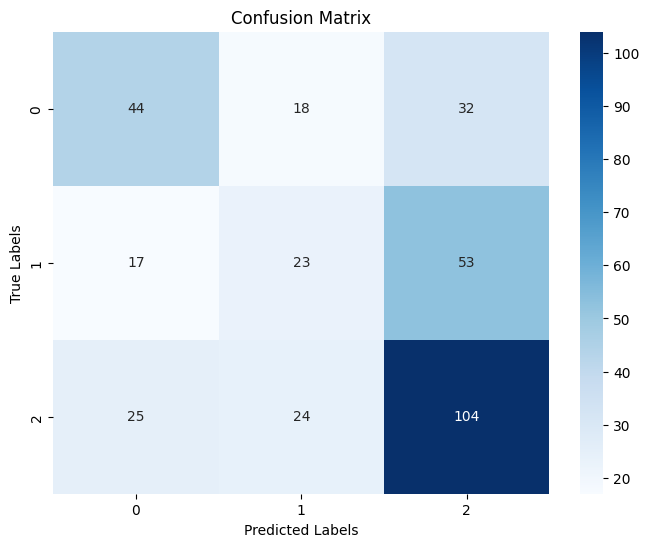

In [74]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()